<a href="https://colab.research.google.com/github/Renzo0o0/Binomial-option-pricing-crr/blob/main/Binomial_option_pricing_crr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parámetros CRR: u=1.0936, d=0.9144, p=0.5338

Árbol de precios del subyacente:
       0           1           2           3           4           5
0  100.0   91.444064   83.620169   76.465681   69.923327   63.940732
1    0.0  109.356469  100.000000   91.444064   83.620169   76.465681
2    0.0    0.000000  119.588373  109.356469  100.000000   91.444064
3    0.0    0.000000    0.000000  130.777623  119.588373  109.356469
4    0.0    0.000000    0.000000    0.000000  143.013790  130.777623
5    0.0    0.000000    0.000000    0.000000    0.000000  156.394832 

Payoffs terminales del call:
[ 0.          0.          0.          9.35646911 30.77762259 56.39483159] 

Árbol de precios de la opción:
           0          1          2          3          4          5
0  10.805934   4.949698   1.380781   0.000000   0.000000   0.000000
1   0.000000  16.124796   8.160330   2.612887   0.000000   0.000000
2   0.000000   0.000000  23.385337  13.159649   4.944431   0.000000
3   0.000000   0.000000   0.

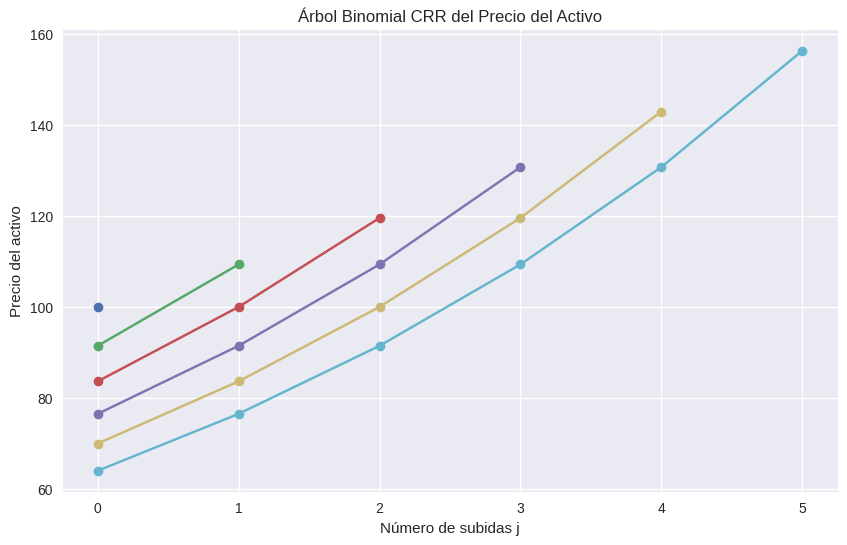

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


# 1. PARÁMETROS DEL PROBLEMA (CRR BINOMIAL MODEL)

# Basado en: Hull, "Options, Futures and Other Derivatives", cap. 13
# Y Wilmott, "Introduces Quantitative Finance", cap. 5

S0 = 100     # precio spot del subyacente
K  = 100      # strike
r  = 0.05     # tasa libre de riesgo (continua)
sigma = 0.20  # volatilidad anual o desviación estándar anual
T = 1         # tiempo a madurez en años
N = 5         # número de pasos del árbol

# Tamaño de paso temporal
dt = T / N

# Factores CRR: u y d derivan de la volatilidad
# Hull: u = e^{σ√Δt}, d = 1/u
u = np.exp(sigma * np.sqrt(dt))
d = 1/u

# Probabilidad riesgo-neutral (no depende de la probabilidad real)
# Wilmott: p = (e^{rΔt} - d) / (u - d)
p = (np.exp(r*dt) - d) / (u - d)
q = 1 - p

print(f"Parámetros CRR: u={u:.4f}, d={d:.4f}, p={p:.4f}\n")



# 2. ÁRBOL DE PRECIOS DEL SUBYACENTE
# price_tree[j,i] = precio luego de i pasos con j subidas

price_tree = np.zeros((N+1, N+1))

for i in range(N + 1):
    for j in range(i + 1):
        price_tree[j, i] = S0 * (u**j) * (d**(i-j))

print("Árbol de precios del subyacente:")
print(pd.DataFrame(price_tree), "\n")


# 3. PAYOFFS TERMINALES DEL CALL EUROPEO


option_tree = np.zeros((N+1, N+1))

for j in range(N+1):
    option_tree[j, N] = max(price_tree[j, N] - K, 0)

print("Payoffs terminales del call:")
print(option_tree[:, N], "\n")


# 4. BACKWARD INDUCTION: PRECIO DE LA OPCIÓN

# Hull: C = e^{-rΔt} [ p C_up + q C_down ]

# Además, en cada nodo inferimos:
# Delta (réplica): Δ = (C_up - C_down) / (S_up - S_down)

# B (bono): B = e^{-rΔt} (C_down - Δ*S_down)

delta_tree = np.zeros((N+1, N+1))
bond_tree  = np.zeros((N+1, N+1))

for i in range(N-1, -1, -1):
    for j in range(i+1):
        Cu = option_tree[j+1, i+1]     # valor si sube
        Cd = option_tree[j,   i+1]     # valor si baja
        Su = price_tree[j+1, i+1]      # precio si sube
        Sd = price_tree[j,   i+1]      # precio si baja

        # Delta del portafolio replicante (Wilmott)
        delta = (Cu - Cd) / (Su - Sd)
        delta_tree[j, i] = delta

        # Bono que completa la réplica
        bond = np.exp(-r*dt) * (Cu - delta * Su)
        bond_tree[j, i] = bond

        # Valor actual de la opción (Hull)
        option_tree[j, i] = np.exp(-r * dt) * (p * Cu + q * Cd)

print("Árbol de precios de la opción:")
print(pd.DataFrame(option_tree), "\n")

print(f"Valor del Call Europeo hoy: {option_tree[0,0]:.4f}\n")


# 5. GREEKS DISCRETAS DEL MODELO BINOMIAL

# Hull/Wilmott: se aproximan vía diferencias finitas del árbol
#Delta (Δ): Mide el cambio en el precio de la opción por cada cambio de $1 en el precio del activo subyacente.
Delta = delta_tree[0,0]
#Gamma (Γ): Indica cuánto cambia la Delta ante un cambio de $1 en el precio del subyacente; mide la aceleración del Delta.
Gamma = (delta_tree[1,1] - delta_tree[0,1]) / ((price_tree[1,1] - price_tree[0,1])/2)
#Theta (Θ): Representa la pérdida de valor de la opción por el simple paso del tiempo (decaimiento temporal), siendo negativa para opciones compradas y positiva para vendidas.
Theta = (option_tree[0,0] - option_tree[0,1]) / dt

print(f"Delta ≈ {Delta:.4f}")
print(f"Gamma ≈ {Gamma:.4f}")
print(f"Theta ≈ {Theta:.4f}\n")



# 6. GRAFICAR EL ÁRBOL DEL SUBYACENTE


plt.figure(figsize=(10, 6))
for i in range(N+1):
    plt.plot(range(i+1), price_tree[:i+1, i], marker="o")
plt.title("Árbol Binomial CRR del Precio del Activo")
plt.xlabel("Número de subidas j")
plt.ylabel("Precio del activo")
plt.grid(True)
plt.show()
